# 將 CH8-量化系統擇時.ipynb 的單股回測系統優化
1. 將一些需要用到的 BaseClass 跟 Implement 搬過來
2. 實作多股回測系統，加入風險控制類別

# 多股票回測系統使用說明

## 功能特色

1. **多股票同時回測**：可以同時對多檔股票進行回測
2. **預設倉位管理**：系統預設使用固定比例倉位管理（50%）
3. **可擴展的倉位管理**：可以傳入不同的倉位管理類別來選擇不同策略

## 倉位管理類別

### 1. FixedRatioPositionManager（固定比例）
- **參數**：
  - `position_ratio`: 每次買入使用的資金比例（預設 0.5）
  - `max_position_ratio`: 最大持倉比例（預設 1.0）

### 2. RiskBasedPositionManager（基於風險）
- **參數**：
  - `risk_per_trade`: 每筆交易風險比例（預設 0.02，即 2%）
  - `atr_multiplier`: ATR 倍數（預設 2.0）
  - `max_position_ratio`: 最大持倉比例（預設 1.0）

### 3. EqualWeightPositionManager（等權重）
- **參數**：
  - `max_stocks`: 最大同時持倉股票數量（預設 10）

### 4. VolatilityBasedPositionManager（基於波動率）
- **參數**：
  - `base_position_ratio`: 基礎倉位比例（預設 0.5）
  - `volatility_window`: 計算波動率的視窗期（預設 20）
  - `max_position_ratio`: 最大持倉比例（預設 1.0）

## 使用範例

```python
# 1. 準備股票資料
stock_data = {
    "TSLA": tsla_df,
    "AAPL": aapl_df,
    "MSFT": msft_df
}

# 2. 定義買入/賣出因子
buy_factors = [
    {"class": BreakoutBuyFactor, "xd": 60},
]
sell_factors = [
    {"class": BreakdownSellFactor, "xd": 20},
]

# 3. 選擇倉位管理策略（可選）
position_manager = FixedRatioPositionManager(position_ratio=0.5)
# 或
position_manager = RiskBasedPositionManager(risk_per_trade=0.02)

# 4. 建立回測器並執行
bt = MultiStockBacktester(
    stock_data=stock_data,
    buy_factors=buy_factors,
    sell_factors=sell_factors,
    initial_capital=1_000_000,
    position_manager=position_manager  # 可選，不傳入則使用預設
)

results, trades, stats = bt.run(show_plot=True)
```

## 自訂倉位管理策略

可以繼承 `BasePositionManager` 來建立自己的倉位管理策略：

```python
class MyCustomPositionManager(BasePositionManager):
    def __init__(self, my_param=0.5):
        super().__init__(my_param=my_param)
        self.my_param = my_param
    
    def calculate_position_size(self, current_price, available_capital, **kwargs):
        # 實作你的倉位計算邏輯
        shares = (available_capital * self.my_param) / current_price
        return shares
```


In [17]:
from alanq.positions import (
    FixedRatioPositionManager,
    RiskBasedPositionManager,
    EqualWeightPositionManager,
    VolatilityBasedPositionManager,
    FixedKellyPositionManager
)
from alanq.backtest import MultiStockBacktester

ImportError: cannot import name 'RiskBasedPositionManager' from 'alanq.positions' (/Users/alan/q-trade/alanq/positions/__init__.py)

In [25]:
# 新增：多股票回測引擎（支援倉位管理）

class MultiStockBacktester:
    """
    多股票回測引擎，支援倉位管理
    """
    
    def __init__(self,
                 stock_data: dict,  # {股票代號: DataFrame}
                 # 將 buy/sell factors 設為可選，作為全局預設
                 buy_factors: list = None,
                 sell_factors: list = None,
                 # 新增 strategy_config 來接收每檔股票的客製化策略
                 strategy_config: dict = None, # {股票代號: {'buy_factors': list, 'sell_factors': list}}
                 initial_capital: float = 1_000_000,
                 position_manager: BasePositionManager = None,
                 slippage_factors: list = None):
        """
        Parameters:
        -----------
        stock_data : dict
            股票資料字典，格式：{股票代號: DataFrame}
            DataFrame 必須包含 'Close', 'High', 'Low', 'Open' 欄位
        buy_factors : list
            買入因子設定列表
        sell_factors : list
            賣出因子設定列表
        initial_capital : float
            初始資金
        position_manager : BasePositionManager
            倉位管理類別實例，如果為 None 則使用 FixedRatioPositionManager
        slippage_factors : list
            滑價因子設定列表（可選）
        strategy_config : dict
            客製化策略字典，格式：{股票代號: {'buy_factors': list, 'sell_factors': list}}
            如果某股票在此字典中，將使用其專屬策略，否則使用全局 buy_factors/sell_factors。
        """
        self.stock_data = stock_data
        # 將全局配置儲存起來
        self.global_buy_factors = buy_factors or []
        self.global_sell_factors = sell_factors or []
        
        # 儲存客製化配置
        self.strategy_config = strategy_config or {}
        
        self.initial_capital = initial_capital
        self.slippage_factors = slippage_factors or []
        self.buy_factors = buy_factors or []
        self.sell_factors = sell_factors or []
        self.initial_capital = initial_capital
        self.slippage_factors = slippage_factors or []
        
        # 倉位管理（預設使用固定比例）
        if position_manager is None:
            self.position_manager = FixedRatioPositionManager(position_ratio=0.5)
        else:
            self.position_manager = position_manager
        
        # 儲存結果
        self.stock_results = {}
        self.trades = None
        self.stats = None
        
        # 內部變數
        self.stock_signals = {}  # 每個股票的訊號
        self.stock_positions = {}  # 每個股票的持倉
        
        # 滑價模型相關變數
        self.slippage_models = {}  # 儲存滑價模型實例的字典 (以 factor_name 為鍵)
        self.slippage_cols = []  # 記錄所有滑價因子欄位名稱的列表
        self.canceled_trades = None  # 儲存被滑價取消的交易紀錄
        
    def run(self, show_plot=False):
        """
        執行回測
        
        Returns:
        --------
        dict : 包含各股票結果的字典
        """
        # 1. 對每個股票產生訊號
        self._apply_factors_to_all_stocks()
        
        # 2. 應用滑價模型（必須在 _run_multi_stock_backtest 之前）
        self._apply_slippage_models()
        
        # 3. 建立統一的交易日曆
        self._create_trading_calendar()
        
        # 4. 執行多股票回測（含倉位管理）
        self._run_multi_stock_backtest()
        
        # 5. 計算績效
        self._compute_performance()
        
        # 6. 提取交易紀錄
        self._extract_all_trades()
        
        # 7. 提取被取消的交易
        self._extract_canceled_trades()
        
        if show_plot:
            self._plot_results()
        
        # 根據是否有滑價，決定回傳數量
        base_results = (self.stock_results, self.trades, self.stats)
        
        if bool(self.slippage_factors):
            # 有滑價模型時，回傳 4 個值
            return (*base_results, self.canceled_trades)
        else:
            # 沒有滑價模型時，只回傳 3 個值
            return base_results
    
    def _apply_factors_to_all_stocks(self):
        """對所有股票應用買入/賣出因子 (支援客製化策略)"""
        for symbol, df in self.stock_data.items():
            # 根據股票代號決定使用的因子列表
            if symbol in self.strategy_config:
                # 使用該股票的客製化策略
                buy_factors = self.strategy_config[symbol].get('buy_factors', [])
                sell_factors = self.strategy_config[symbol].get('sell_factors', [])
            else:
                # 使用全局策略
                buy_factors = self.global_buy_factors
                sell_factors = self.global_sell_factors
            
            # 複製資料
            df_copy = df.copy()
            
            # 初始化訊號欄位
            df_copy["buy_factor_trigger"] = ""
            df_copy["sell_factor_trigger"] = ""
            df_copy["slippage_trigger"] = ""
            
            buy_cols = []
            sell_cols = []
            
            # 應用買入因子 (使用動態選取的 buy_factors)
            for f in buy_factors:
                FactorClass = f["class"]
                params = {k: v for k, v in f.items() if k != "class"}
                factor = FactorClass(df_copy, **params)
                
                col = factor.factor_name
                buy_cols.append(col)
                df_copy[col] = factor.generate()
                
                # 記錄觸發因子
                df_copy.loc[df_copy[col] == 1, "buy_factor_trigger"] += (col + ";")
            
            # 應用賣出因子 (使用動態選取的 sell_factors)
            for f in sell_factors:
                FactorClass = f["class"]
                params = {k: v for k, v in f.items() if k != "class"}
                factor = FactorClass(df_copy, **params)
                
                col = factor.factor_name
                sell_cols.append(col)
                df_copy[col] = factor.generate()
                
                # 記錄觸發因子
                df_copy.loc[df_copy[col] == 0, "sell_factor_trigger"] += (col + ";")
            
            # 儲存結果
            self.stock_signals[symbol] = {
                'df': df_copy,
                'buy_cols': buy_cols,
                'sell_cols': sell_cols
            }
    
    def _apply_slippage_models(self):
        """實例化所有滑價模型並儲存在 self.slippage_models 字典中"""
        if not self.slippage_factors:
            return
        
        # 為每個股票建立滑價模型
        for symbol, signals in self.stock_signals.items():
            df = signals['df']
            
            for sf in self.slippage_factors:
                SlippageClass = sf["class"]
                
                # 從設定中提取參數
                params = {k: v for k, v in sf.items() if k != "class"}
                
                # 實例化滑價類別
                model_instance = SlippageClass(df, **params)
                
                col = model_instance.factor_name
                if col not in self.slippage_cols:
                    self.slippage_cols.append(col)
                
                # 以 (symbol, factor_name) 為鍵儲存實例
                key = (symbol, col)
                self.slippage_models[key] = model_instance
    
    def _create_trading_calendar(self):
        """建立統一的交易日曆（所有股票的交集日期）"""
        all_dates = None
        
        for symbol, signals in self.stock_signals.items():
            df = signals['df']
            if all_dates is None:
                all_dates = set(df.index)
            else:
                all_dates = all_dates.intersection(set(df.index))
        
        # 轉換為排序後的列表
        self.trading_dates = sorted(list(all_dates))
    
    def _run_multi_stock_backtest(self):
        """
        執行多股票回測，包含倉位管理
        """
        # 初始化資金和持倉
        cash = self.initial_capital
        holdings = {}  # {股票代號: 股數}
        
        # 初始化結果記錄
        for symbol in self.stock_data.keys():
            self.stock_positions[symbol] = []
        
        equity_history = []
        cash_history = []
        
        # 逐日回測
        for date in self.trading_dates:
            # 計算當前總權益
            total_equity = cash
            
            # 更新每個股票的持倉市值
            for symbol in holdings.keys():
                if symbol in self.stock_signals:
                    df = self.stock_signals[symbol]['df']
                    if date in df.index:
                        current_price = df.loc[date, 'Close']
                        total_equity += holdings[symbol] * current_price
            
            # 處理每個股票的交易訊號
            for symbol, signals in self.stock_signals.items():
                df = signals['df']
                buy_cols = signals['buy_cols']
                sell_cols = signals['sell_cols']
                
                if date not in df.index:
                    # 如果該日期沒有資料，維持現狀
                    current_shares = holdings.get(symbol, 0)
                    self.stock_positions[symbol].append(current_shares)
                    continue
                
                row = df.loc[date]
                current_price = row['Close']
                current_shares = holdings.get(symbol, 0)
                
                # 初始化當天的滑價觸發記錄
                current_slippage_trigger = ""
                
                # 檢查買入訊號
                buy_signal = any(row[col] == 1 for col in buy_cols) if buy_cols else False
                
                # 檢查賣出訊號
                sell_signal = any(row[col] == 0 for col in sell_cols) if sell_cols else False
                
                # 處理賣出（優先）
                if sell_signal and current_shares > 0:
                    # 應用滑價模型
                    can_sell = True
                    final_sell_price = current_price  # 預設成交價
                    
                    # 檢查所有設定為 "sell" 的滑價模型
                    for col in self.slippage_cols:
                        key = (symbol, col)
                        if key in self.slippage_models:
                            model = self.slippage_models[key]
                            
                            if model.params.get("action") == "sell":
                                model.set_current_data(row)
                                adjusted_price = model.fit_price()
                                
                                # 如果滑價計算的價格為 0 或 -Inf，視為撤單（賣不出）
                                if adjusted_price == 0 or adjusted_price == -np.inf:
                                    can_sell = False
                                    current_slippage_trigger += (col + ";")
                                    break
                                else:
                                    # 取最差的價格 (即最低的賣價) 作為最終成交價
                                    final_sell_price = min(final_sell_price, adjusted_price)
                    
                    if can_sell:
                        # 全部賣出
                        cash += current_shares * final_sell_price
                        holdings[symbol] = 0
                        current_shares = 0
                    
                    # 記錄當天的滑價觸發事件
                    df.loc[date, "slippage_trigger"] = current_slippage_trigger
                
                # 處理買入
                elif buy_signal and current_shares == 0:
                    # 應用滑價模型
                    can_buy = True
                    final_buy_price = current_price  # 預設成交價
                    
                    # 檢查所有設定為 "buy" 的滑價模型
                    for col in self.slippage_cols:
                        key = (symbol, col)
                        if key in self.slippage_models:
                            model = self.slippage_models[key]
                            
                            if model.params.get("action") == "buy":
                                model.set_current_data(row)
                                adjusted_price = model.fit_price()
                                
                                # 如果滑價計算的價格為 Inf，視為撤單（買不到）
                                if adjusted_price == np.inf:
                                    can_buy = False
                                    current_slippage_trigger += (col + ";")
                                    break
                                else:
                                    # 取最差的價格 (即最高的買價) 作為最終成交價
                                    final_buy_price = max(final_buy_price, adjusted_price)
                    
                    if can_buy:
                        # 計算可用資金（考慮現有持倉）
                        available_capital = cash
                        
                        # 準備倉位計算的參數
                        position_kwargs = {
                            'total_capital': total_equity,
                            'current_holdings': len([s for s in holdings.values() if s > 0])
                        }
                        
                        # 如果有 ATR，加入參數
                        if 'atr14' in df.columns:
                            position_kwargs['atr'] = row.get('atr14', current_price * 0.02)
                        
                        # 如果有歷史報酬率，加入參數
                        if 'log_ret' in df.columns:
                            returns = df.loc[:date, 'log_ret'].dropna()
                            if len(returns) > 0:
                                position_kwargs['returns'] = returns
                        
                        # 計算應該買入的股數（使用滑價調整後的價格）
                        shares_to_buy = self.position_manager.calculate_position_size(
                            current_price=final_buy_price,
                            available_capital=available_capital,
                            **position_kwargs
                        )
                        
                        # 計算實際買入金額（使用滑價調整後的價格）
                        cost = shares_to_buy * final_buy_price
                        
                        # 檢查資金是否足夠
                        if cost <= cash and shares_to_buy > 0:
                            cash -= cost
                            holdings[symbol] = shares_to_buy
                            current_shares = shares_to_buy
                    
                    # 記錄當天的滑價觸發事件（已在買入/賣出邏輯中更新）
                    pass
                
                # 記錄當天的滑價觸發事件（確保所有日期都有記錄）
                df.loc[date, "slippage_trigger"] = current_slippage_trigger
                
                # 記錄持倉
                self.stock_positions[symbol].append(current_shares)
            
            # 重新計算總權益（處理完所有交易後）
            total_equity = cash
            for symbol in holdings.keys():
                if symbol in self.stock_signals:
                    df = self.stock_signals[symbol]['df']
                    if date in df.index:
                        current_price = df.loc[date, 'Close']
                        total_equity += holdings[symbol] * current_price
            
            # 記錄資金和權益
            equity_history.append(total_equity)
            cash_history.append(cash)
        
        # 儲存結果
        self.equity_history = pd.Series(equity_history, index=self.trading_dates)
        self.cash_history = pd.Series(cash_history, index=self.trading_dates)
        
        # 將持倉資訊加入每個股票的 DataFrame
        for symbol, positions in self.stock_positions.items():
            df = self.stock_signals[symbol]['df']
            df['position'] = pd.Series(positions, index=self.trading_dates)
            df['position'] = df['position'].fillna(0)
    
    def _compute_performance(self):
        """計算績效指標"""
        # 計算每日報酬率
        equity_series = self.equity_history
        daily_returns = equity_series.pct_change().dropna()
        
        # 總報酬率
        total_return = (equity_series.iloc[-1] / self.initial_capital)
        
        # 年化報酬率
        days = (equity_series.index[-1] - equity_series.index[0]).days
        years = days / 365.0 if days > 0 else 1.0
        annual_return = (1 + total_return) ** (1 / years) - 1 if years > 0 else total_return
        
        # 波動率和 Sharpe
        if len(daily_returns) > 1 and daily_returns.std() > 0:
            volatility = daily_returns.std() * np.sqrt(252)
            sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) if daily_returns.std() > 0 else np.nan
        else:
            volatility = np.nan
            sharpe = np.nan
        
        # 最大回撤
        roll_max = equity_series.cummax()
        drawdown = equity_series / roll_max - 1.0
        max_drawdown = drawdown.min()
        
        # 儲存統計資料
        self.stats = {
            "總報酬率": total_return,
            "年化報酬率": annual_return,
            "年化波動率": volatility,
            "Sharpe": sharpe,
            "最大回撤": max_drawdown,
            "最終權益": equity_series.iloc[-1],
            "最終現金": self.cash_history.iloc[-1],
        }
        
        # 儲存權益曲線
        self.stock_results['equity_curve'] = equity_series
        self.stock_results['cash_curve'] = self.cash_history
    
    def _extract_all_trades(self):
        """提取所有交易紀錄"""
        all_trades = []
        
        for symbol, signals in self.stock_signals.items():
            df = signals['df']
            pos = df['position']
            change = pos.diff()
            
            entries = change[change > 0].index
            exits = change[change < 0].index
            
            # 如果最後還有持倉，加入最後一個日期作為出場
            if len(entries) > len(exits):
                exits = list(exits) + [df.index[-1]]
            
            for entry_date, exit_date in zip(entries, exits):
                entry_price = df.loc[entry_date, 'Close']
                exit_price = df.loc[exit_date, 'Close']
                shares = df.loc[entry_date, 'position']
                
                all_trades.append({
                    "symbol": symbol,
                    "entry_date": entry_date,
                    "exit_date": exit_date,
                    "entry_price": entry_price,
                    "exit_price": exit_price,
                    "shares": shares,
                    "holding_days": (exit_date - entry_date).days,
                    "return_pct": (exit_price / entry_price) - 1,
                    "pnl": (exit_price - entry_price) * shares,
                    "buy_factor": df.loc[entry_date, "buy_factor_trigger"],
                    "sell_factor": df.loc[exit_date, "sell_factor_trigger"],
                })
        
        self.trades = pd.DataFrame(all_trades)
    
    def _extract_canceled_trades(self):
        """產生被滑價取消的交易紀錄"""
        if not self.slippage_factors:
            self.canceled_trades = pd.DataFrame()
            return
        
        all_canceled = []
        
        for symbol, signals in self.stock_signals.items():
            df = signals['df'].copy()
            
            # 為了判斷是否為「嘗試買入但失敗」或「嘗試賣出但失敗」，需要前一天的 position
            df["prev_position"] = df["position"].shift(1).fillna(0)
            
            # --- 1. 篩選出被取消的買入點 ---
            canceled_buy_mask = (
                (df["buy_factor_trigger"].str.len() > 0) &  # 有買入訊號
                (df["prev_position"] == 0) &                # 試圖買入前是空手
                (df["position"] == 0) &                     # 交易後仍是空手 (買入失敗)
                (df["slippage_trigger"].str.len() > 0)      # 失敗原因是滑價觸發
            )
            
            # --- 2. 篩選出被取消的賣出點 ---
            canceled_sell_mask = (
                (df["sell_factor_trigger"].str.len() > 0) & # 有賣出訊號
                (df["prev_position"] > 0) &                  # 試圖賣出前是持股
                (df["position"] > 0) &                     # 交易後仍是持股 (賣出失敗)
                (df["slippage_trigger"].str.len() > 0)      # 失敗原因是滑價觸發
            )
            
            canceled_df = df[canceled_buy_mask | canceled_sell_mask].copy()
            
            for date, row in canceled_df.iterrows():
                action = "Canceled Buy" if row["prev_position"] == 0 else "Canceled Sell"
                
                all_canceled.append({
                    "symbol": symbol,
                    "date": date,
                    "action": action,
                    "price": row["Close"],  # 紀錄當天收盤價
                    "signal_trigger": row["buy_factor_trigger"] if action == "Canceled Buy" else row["sell_factor_trigger"],
                    "slippage_factor": row["slippage_trigger"],
                    "current_holding": row["position"]
                })
        
        self.canceled_trades = pd.DataFrame(all_canceled)
    
    def _plot_results(self):
        """Plots the backtest results."""
        # Create two subplots: Equity Curve and Capital Allocation
        fig, axes = plt.subplots(2, 1, figsize=(16, 10))
        
        # --- Top Subplot: Equity Curve ---
        
        # Plot the strategy's total equity over time
        axes[0].plot(self.equity_history.index, self.equity_history.values, 
                    label='Strategy Equity', linewidth=2)
        
        # Draw a dashed line for the initial capital
        axes[0].axhline(y=self.initial_capital, color='r', linestyle='--', 
                    label=f'Initial Capital ({self.initial_capital:,.0f})')
                    
        axes[0].set_title('Multi-Stock Backtest - Equity Curve', fontsize=14)
        axes[0].set_ylabel('Equity', fontsize=12) # Note: Adjust currency label as needed
        axes[0].legend()
        axes[0].grid(True)
        
        # --- Bottom Subplot: Capital Allocation ---
        
        # Calculate the current market value of the holdings (Position Value)
        position_value = self.equity_history - self.cash_history
        
        # Plot Cash and Position Value
        axes[1].plot(self.cash_history.index, self.cash_history.values, 
                    label='Cash', alpha=0.7)
        axes[1].plot(position_value.index, position_value.values, 
                    label='Position Value', alpha=0.7)
                    
        axes[1].set_title('Capital Allocation', fontsize=14)
        axes[1].set_xlabel('Date', fontsize=12)
        axes[1].set_ylabel('Amount', fontsize=12) # Note: Adjust currency label as needed
        axes[1].legend()
        axes[1].grid(True)
        
        plt.tight_layout()
        plt.show()

In [26]:
# =========================================================
# 多股票回測範例
# =========================================================

# 下載多檔股票資料
import yfinance as yf

# 準備多檔股票資料
symbols = ["TSLA", "AAPL", "MSFT"]

# 可以只使用單一股票跟前一章（CH8-量化系統擇時.ipynb）比較
# symbols = ["TSLA"]

stock_data = {}

for symbol in symbols:
    df = yf.download(symbol, start="2020-01-01")
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(1)
    stock_data[symbol] = df

print(f"已下載 {len(stock_data)} 檔股票資料")
for symbol, df in stock_data.items():
    print(f"{symbol}: {len(df)} 筆資料，日期範圍 {df.index[0]} 至 {df.index[-1]}")


/var/folders/k0/mjnvdkdj7sn_zbtz76h68xr40000gn/T/ipykernel_32526/3467642766.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start="2020-01-01")
[*********************100%***********************]  1 of 1 completed
/var/folders/k0/mjnvdkdj7sn_zbtz76h68xr40000gn/T/ipykernel_32526/3467642766.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start="2020-01-01")
[*********************100%***********************]  1 of 1 completed
/var/folders/k0/mjnvdkdj7sn_zbtz76h68xr40000gn/T/ipykernel_32526/3467642766.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start="2020-01-01")
[*********************100%***********************]  1 of 1 completed

已下載 3 檔股票資料
TSLA: 1478 筆資料，日期範圍 2020-01-02 00:00:00 至 2025-11-17 00:00:00
AAPL: 1478 筆資料，日期範圍 2020-01-02 00:00:00 至 2025-11-17 00:00:00
MSFT: 1478 筆資料，日期範圍 2020-01-02 00:00:00 至 2025-11-17 00:00:00


範例 1：固定比例倉位管理（預設）


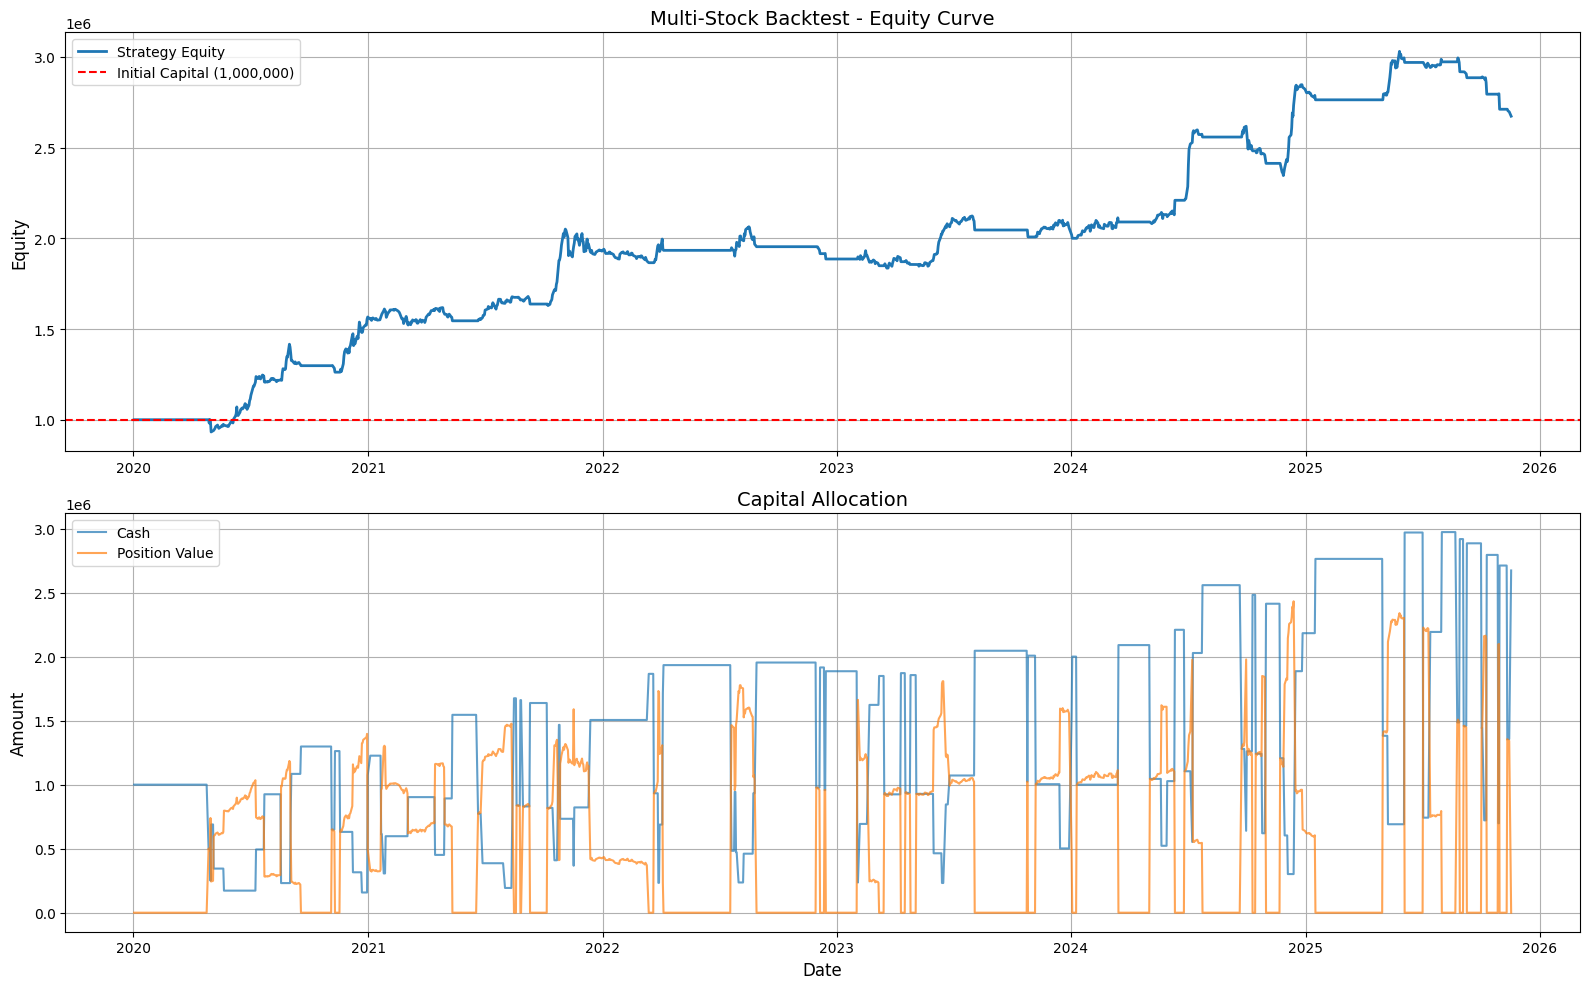


=== 績效指標 ===
總報酬率: 2.6728
年化報酬率: 0.2477
年化波動率: 0.1312
Sharpe: 1.3441
最大回撤: -0.1179
最終權益: 2672849.0394
最終現金: 2672849.0394

=== 交易紀錄（前 10 筆） ===
  symbol entry_date  exit_date  entry_price  exit_price       shares  \
0   TSLA 2020-04-27 2020-05-01    53.250000   46.754665  9389.671362   
1   TSLA 2020-05-21 2020-07-10    55.173332  102.976669  3122.028863   
2   TSLA 2020-08-18 2020-09-02   125.806000  149.123337  3675.837274   
3   TSLA 2020-11-18 2020-12-31   162.213333  235.223328  3890.463510   
4   TSLA 2021-01-25 2021-01-28   293.600006  278.476654  1044.164676   
5   TSLA 2021-08-02 2021-08-16   236.556671  228.723328   816.521962   
6   TSLA 2021-10-07 2021-10-25   264.536682  341.619995  3095.174594   
7   TSLA 2021-10-27 2021-12-13   345.953339  322.136658  2119.891579   
8   TSLA 2022-03-22 2022-04-05   331.326660  363.753326  2815.010653   
9   TSLA 2022-07-21 2022-07-26   271.706665  258.859985  1779.088079   

   holding_days  return_pct            pnl  \
0             4  

In [27]:
# 範例 1：使用固定比例倉位管理（預設）
print("=" * 60)
print("範例 1：固定比例倉位管理（預設）")
print("=" * 60)

buy_factors = [
    {"class": BreakoutBuyFactor, "xd": 60},
    {"class": BreakoutBuyFactor, "xd": 42},
]

sell_factors = [
    {"class": BreakdownSellFactor, "xd": 120},
    {"class": AtrStopSellFactor, "stop_loss_n": 0.5, "stop_win_n": 3.0}
]

# 使用預設的固定比例倉位管理（50%）
bt1 = MultiStockBacktester(
    stock_data=stock_data,
    buy_factors=buy_factors,
    sell_factors=sell_factors,
    initial_capital=1_000_000,
)

results1, trades1, stats1 = bt1.run(show_plot=True)

print("\n=== 績效指標 ===")
for k, v in stats1.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v:,.0f}")

print(f"\n=== 交易紀錄（前 10 筆） ===")
print(trades1.head(10))

print(f"\n總交易次數: {len(trades1)}")
print(f"各股票交易次數:")
print(trades1.groupby('symbol').size())


範例 2：基於風險的倉位管理


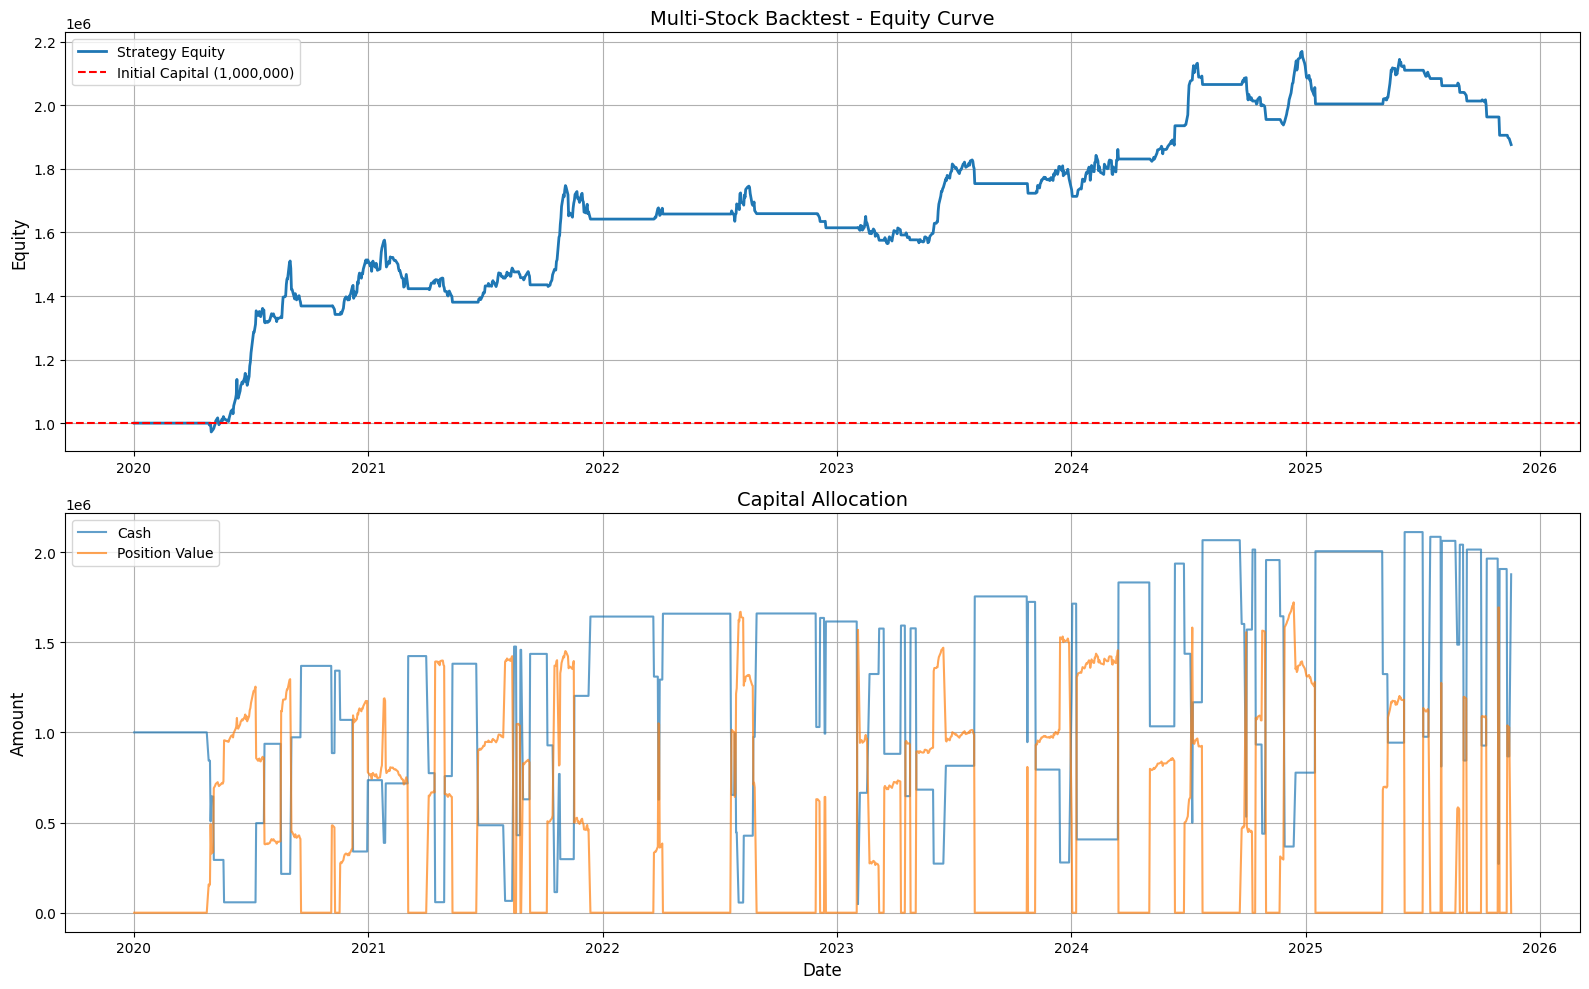


=== 績效指標 ===
總報酬率: 1.8765
年化報酬率: 0.1969
年化波動率: 0.1130
Sharpe: 1.0072
最大回撤: -0.1353
最終權益: 1876538.6003
最終現金: 1876538.6003

總交易次數: 57


In [28]:
# 範例 2：使用基於風險的倉位管理
print("=" * 60)
print("範例 2：基於風險的倉位管理")
print("=" * 60)

# 建立基於風險的倉位管理器
risk_position_manager = RiskBasedPositionManager(
    risk_per_trade=0.02,  # 每筆交易風險 2%
    atr_multiplier=2.0,   # ATR 倍數
    max_position_ratio=1.0  # 最大持倉比例 100%
)

bt2 = MultiStockBacktester(
    stock_data=stock_data,
    buy_factors=buy_factors,
    sell_factors=sell_factors,
    initial_capital=1_000_000,
    position_manager=risk_position_manager  # 傳入自訂倉位管理器
)

results2, trades2, stats2 = bt2.run(show_plot=True)

print("\n=== 績效指標 ===")
for k, v in stats2.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v:,.0f}")

print(f"\n總交易次數: {len(trades2)}")


範例 3：等權重倉位管理


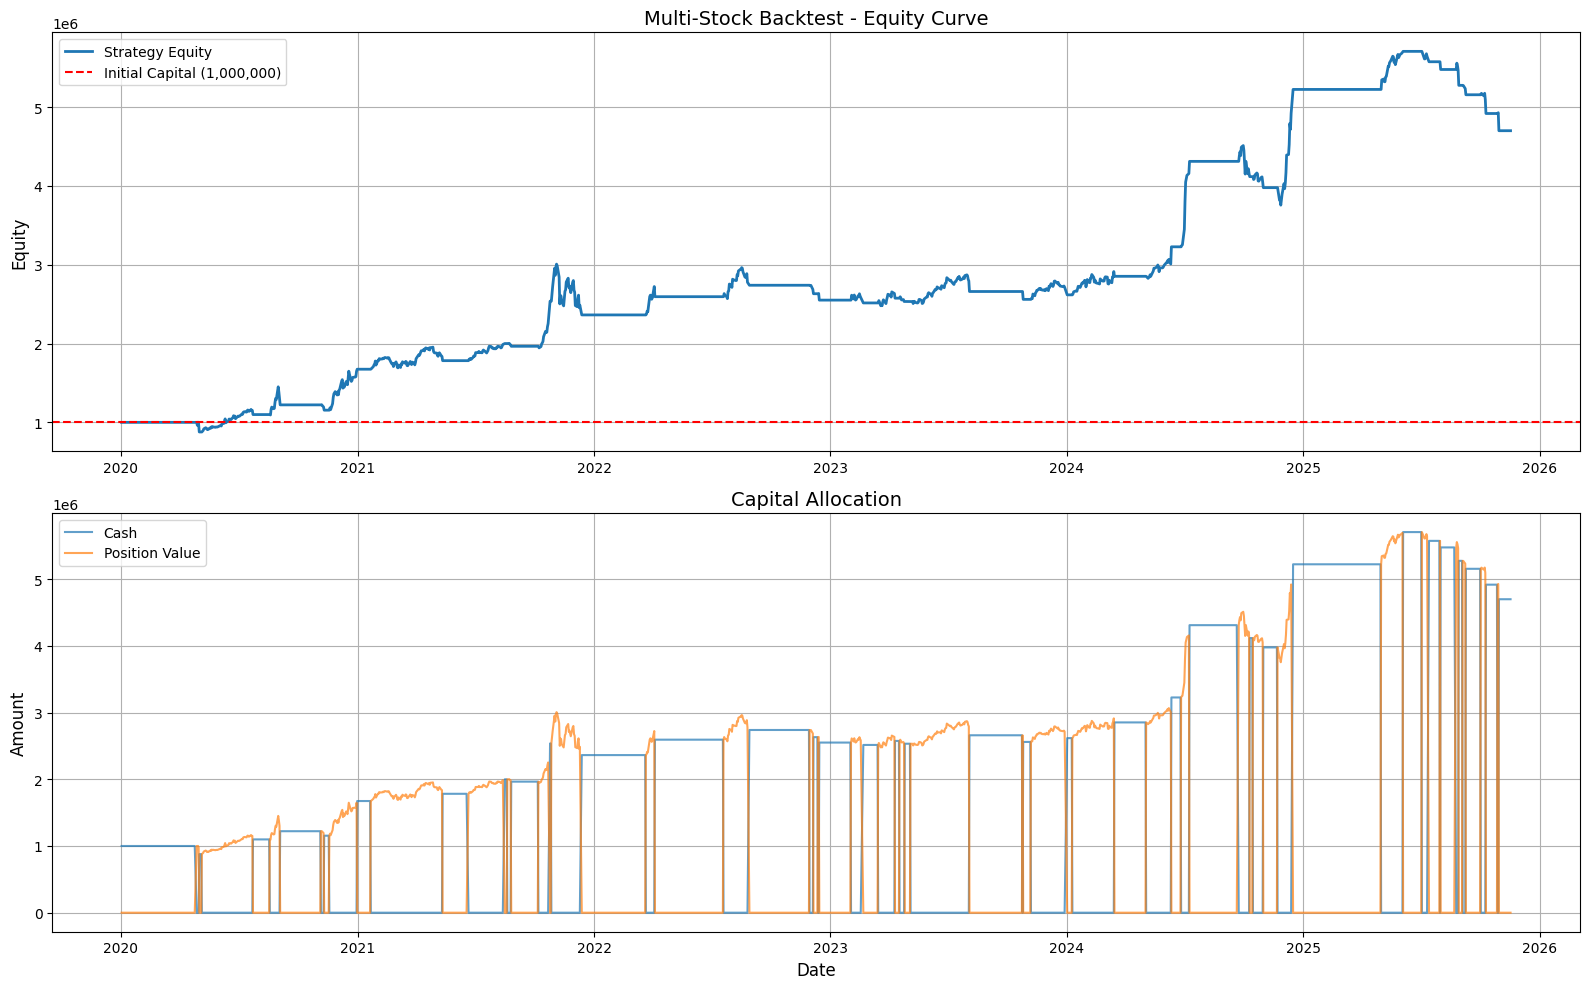


=== 績效指標 ===
總報酬率: 4.7001
年化報酬率: 0.3445
年化波動率: 0.2340
Sharpe: 1.2451
最大回撤: -0.2142
最終權益: 4700145.3285
最終現金: 4700145.3285

總交易次數: 34

各股票交易次數:
symbol
AAPL    11
MSFT    12
TSLA    11
dtype: int64


In [29]:
# 範例 3：使用等權重倉位管理
print("=" * 60)
print("範例 3：等權重倉位管理")
print("=" * 60)

# 建立等權重倉位管理器
equal_weight_manager = EqualWeightPositionManager(
    max_stocks=3  # 最多同時持有 3 檔股票
)

bt3 = MultiStockBacktester(
    stock_data=stock_data,
    buy_factors=buy_factors,
    sell_factors=sell_factors,
    initial_capital=1_000_000,
    position_manager=equal_weight_manager
)

results3, trades3, stats3 = bt3.run(show_plot=True)

print("\n=== 績效指標 ===")
for k, v in stats3.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v:,.0f}")

print(f"\n總交易次數: {len(trades3)}")
print(f"\n各股票交易次數:")
print(trades3.groupby('symbol').size())


範例：使用 Fixed Kelly 倉位管理
--- Fixed Kelly PM Initialized ---
Win Rate (p): 0.5500, Odds Ratio (r): 1.2000
Calculated Kelly Ratio (f): 0.0875
----------------------------------


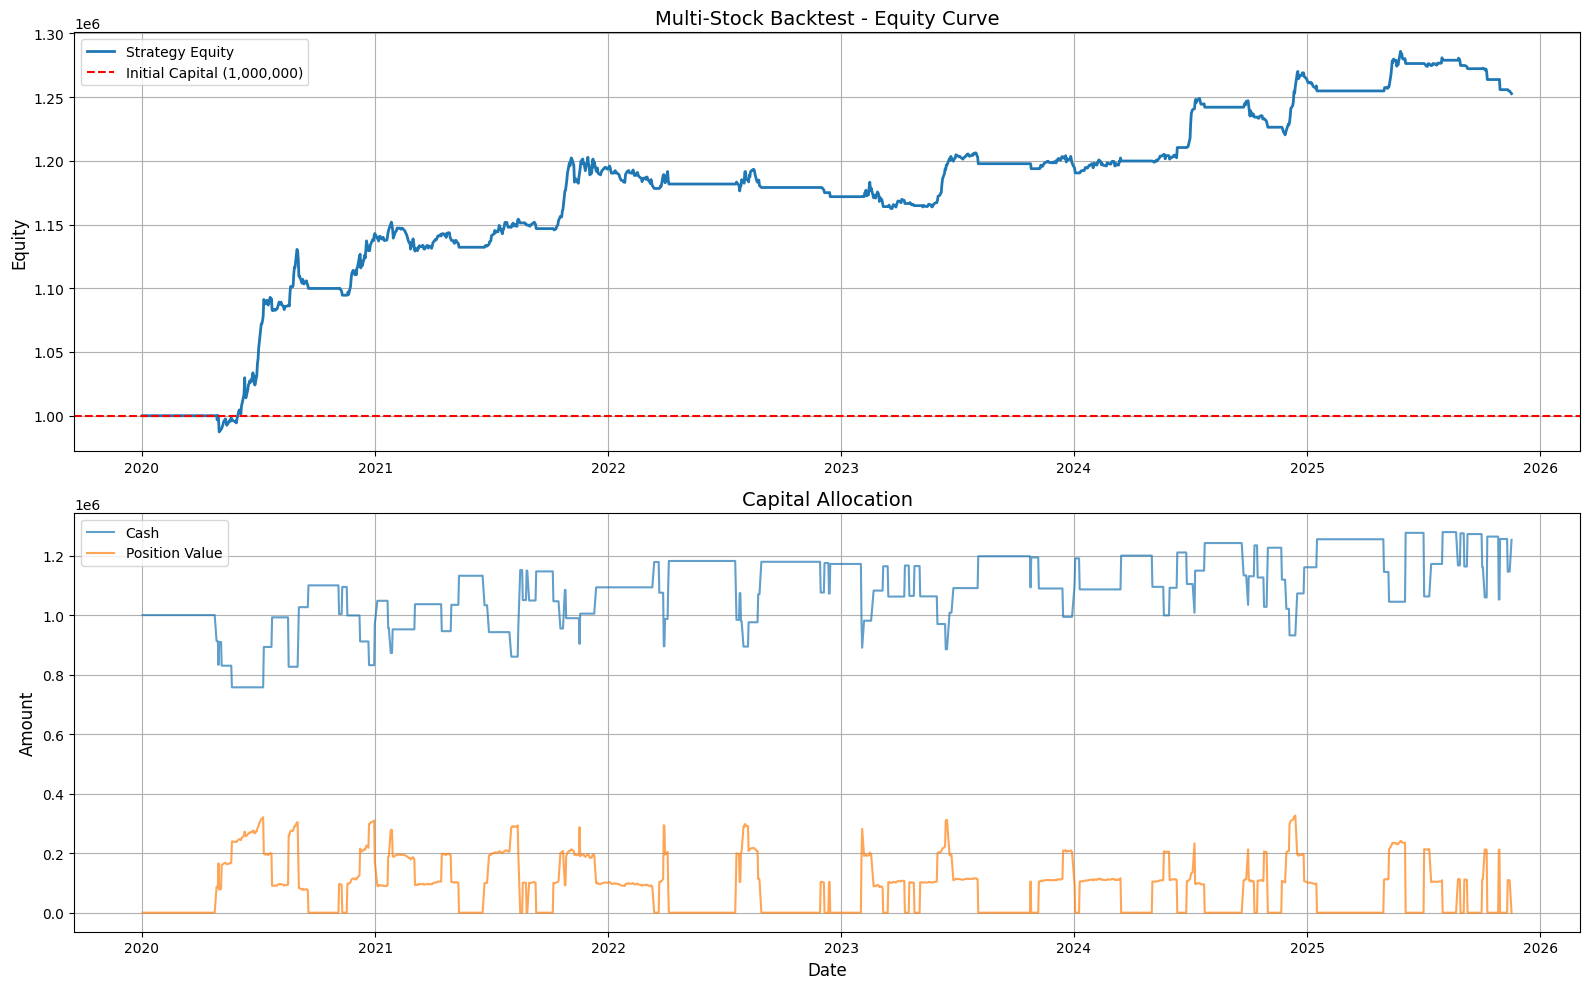


=== 績效指標 ===
總報酬率: 1.2527
年化報酬率: 0.1481
年化波動率: 0.0324
Sharpe: 1.2028
最大回撤: -0.0334
最終權益: 1252652.5320
最終現金: 1252652.5320

總交易次數: 65

各股票交易次數:
symbol
AAPL    22
MSFT    22
TSLA    21
dtype: int64


In [30]:
# 範例 4：Kelly公式的倉位管理

print("=" * 60)
print("範例：使用 Fixed Kelly 倉位管理")
print("=" * 60)

# 1. 建立 Fixed Kelly 倉位管理器
# 假設策略的預估參數為 p=0.55, r=1.2 (約產生 4.5% 的 Kelly 比例)
fixed_kelly_manager = FixedKellyPositionManager(
    win_rate=0.55, 
    odds_ratio=1.2, 
    full_kelly_ratio=0.5,  # 使用保守的半 Kelly 投入 (50%)
    max_position_ratio=1.0 # 最大倉位 100%
)

# FixedKellyPositionManager 在初始化時會打印計算出的 Kelly 比例

bt_kelly = MultiStockBacktester(
    stock_data=stock_data,
    buy_factors=buy_factors,
    sell_factors=sell_factors,
    initial_capital=1_000_000,
    position_manager=fixed_kelly_manager
)

# 執行回測並繪圖
# 假設 bt_kelly.run() 會返回 results, trades, stats
results_kelly, trades_kelly, stats_kelly = bt_kelly.run(show_plot=True)

print("\n=== 績效指標 ===")
for k, v in stats_kelly.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v:,.0f}")

print(f"\n總交易次數: {len(trades_kelly)}")
print(f"\n各股票交易次數:")
print(trades_kelly.groupby('symbol').size())

範例 4：比較不同倉位管理策略
--- Fixed Kelly PM Initialized ---
Win Rate (p): 0.5500, Odds Ratio (r): 1.2000
Calculated Kelly Ratio (f): 0.0875
----------------------------------

=== 倉位管理策略比較 ===
           策略名稱     總報酬率    年化報酬率   Sharpe      最大回撤  交易次數         最終權益
fix ratio (50%) 2.672849 0.247665 1.344143 -0.117932    65 2.672849e+06
fix ratio (30%) 1.930908 0.200686 1.292756 -0.081050    65 1.930908e+06
     risk based 1.876539 0.196868 1.007204 -0.135252    57 1.876539e+06
   equal weight 4.700145 0.344510 1.245063 -0.214243    34 4.700145e+06
    Fixed Kelly 1.252653 0.148121 1.202801 -0.033412    65 1.252653e+06


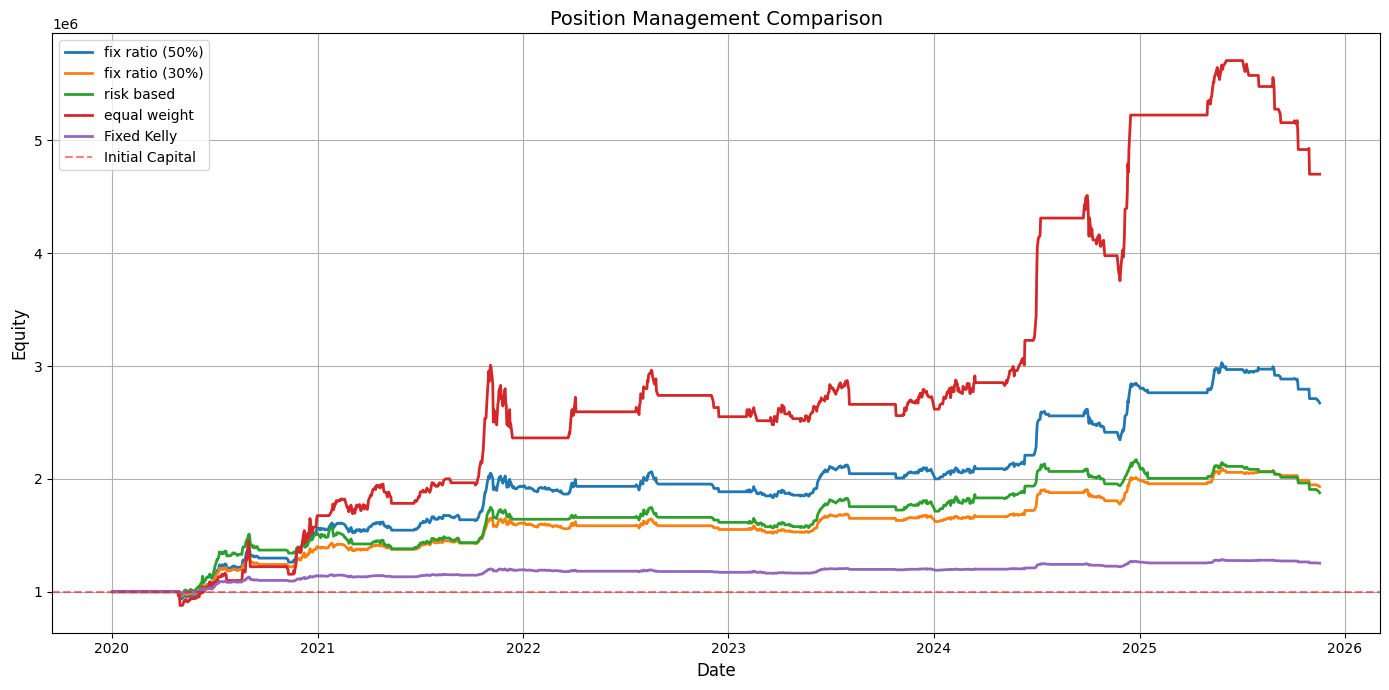

In [31]:
# 範例 5：比較不同倉位管理策略
print("=" * 60)
print("範例 4：比較不同倉位管理策略")
print("=" * 60)

# 定義不同的倉位管理策略
position_managers = {
    "fix ratio (50%)": FixedRatioPositionManager(position_ratio=0.5),
    "fix ratio (30%)": FixedRatioPositionManager(position_ratio=0.3),
    "risk based": RiskBasedPositionManager(risk_per_trade=0.02, atr_multiplier=2.0),
    "equal weight": EqualWeightPositionManager(max_stocks=3),
    "Fixed Kelly": FixedKellyPositionManager(win_rate=0.55, odds_ratio=1.2, full_kelly_ratio=0.5, max_position_ratio=1.0)
}

comparison_results = []

for name, pm in position_managers.items():
    bt = MultiStockBacktester(
        stock_data=stock_data,
        buy_factors=buy_factors,
        sell_factors=sell_factors,
        initial_capital=1_000_000,
        position_manager=pm
    )
    
    results, trades, stats = bt.run(show_plot=False)
    
    comparison_results.append({
        "策略名稱": name,
        "總報酬率": stats["總報酬率"],
        "年化報酬率": stats["年化報酬率"],
        "Sharpe": stats["Sharpe"],
        "最大回撤": stats["最大回撤"],
        "交易次數": len(trades),
        "最終權益": stats["最終權益"],
    })

comparison_df = pd.DataFrame(comparison_results)
print("\n=== 倉位管理策略比較 ===")
print(comparison_df.to_string(index=False))

# 繪製權益曲線比較
fig, ax = plt.subplots(figsize=(14, 7))

for name, pm in position_managers.items():
    bt = MultiStockBacktester(
        stock_data=stock_data,
        buy_factors=buy_factors,
        sell_factors=sell_factors,
        initial_capital=1_000_000,
        position_manager=pm
    )
    results, trades, stats = bt.run(show_plot=False)
    ax.plot(results['equity_curve'].index, 
            results['equity_curve'].values, 
            label=name, linewidth=2)

ax.axhline(y=1_000_000, color='r', linestyle='--', alpha=0.5, label='Initial Capital')
ax.set_title('Position Management Comparison', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Equity', fontsize=12)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


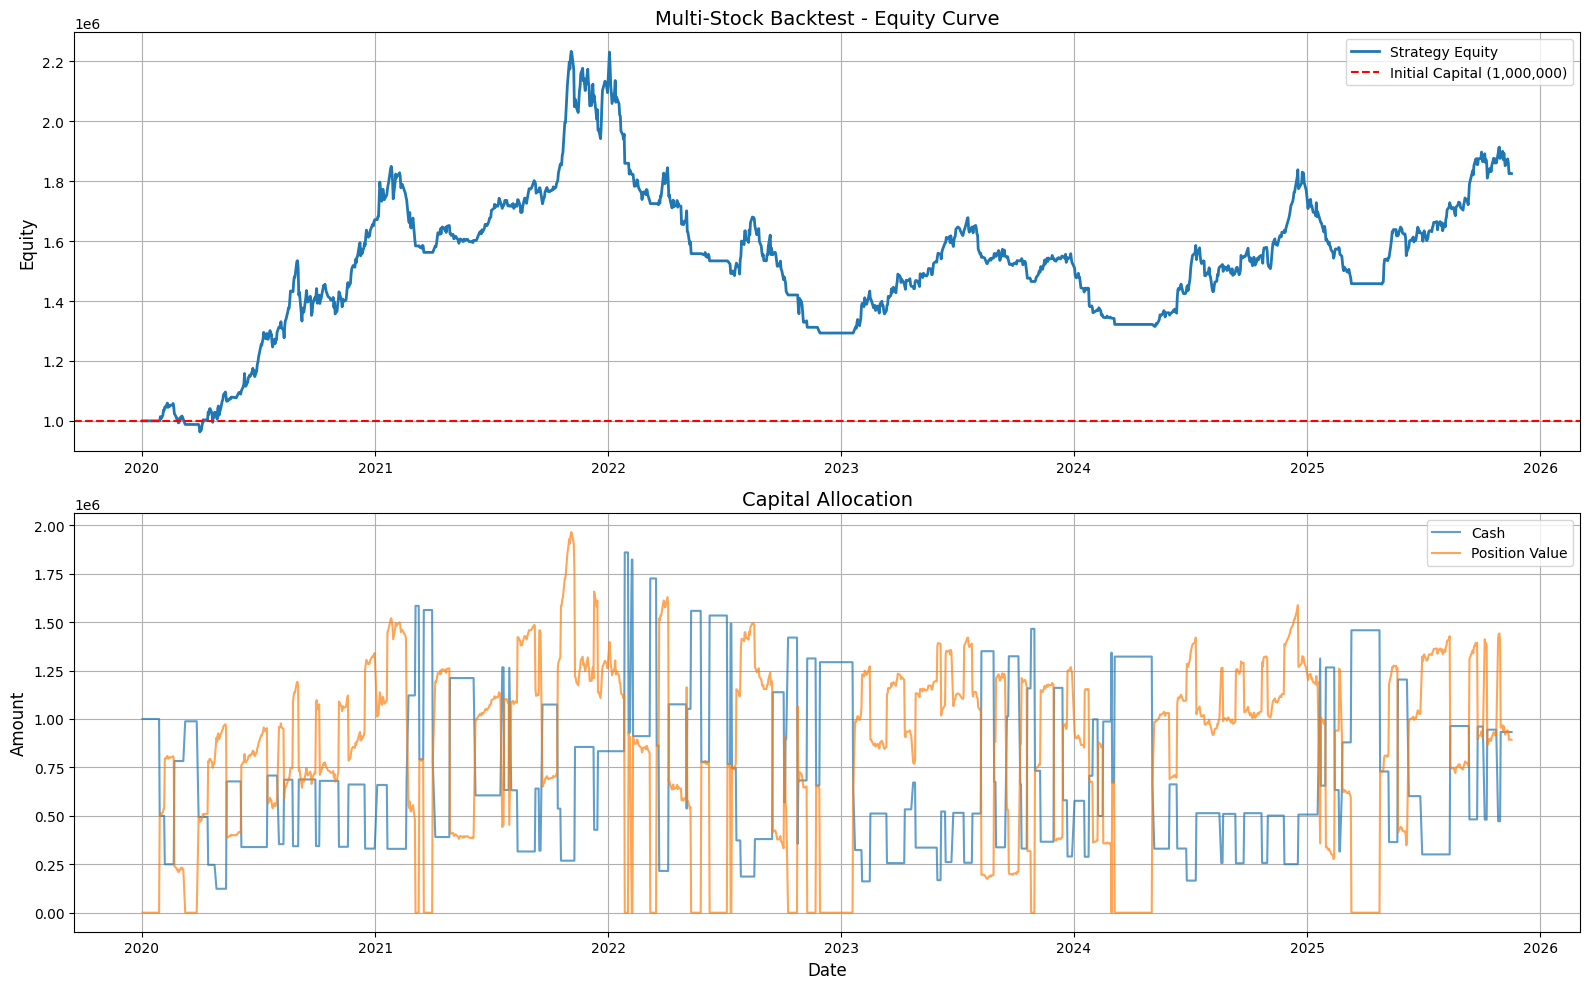


=== 績效指標 ===
總報酬率: 1.8253
年化報酬率: 0.1932
年化波動率: 0.1836
Sharpe: 0.6513
最大回撤: -0.4210
最終權益: 1825328.3251
最終現金: 932585.9806

總交易次數: 75

各股票交易次數:
symbol
AAPL    15
MSFT    51
TSLA     9
dtype: int64


In [32]:
# 範例6：多股票不同因子進行擇時
# 針對 TSLA 的策略
buy_factors_tsla = [{'xd': 42, 'class': BreakoutBuyFactor}]
sell_factors_tsla = [{'xd': 60, 'class': BreakdownSellFactor}]

# 針對 AAPL 的策略
buy_factors_aapl = [{'xd': 21, 'class': BreakoutBuyFactor}]
sell_factors_aapl = [{'xd': 42, 'class': BreakdownSellFactor}]

# 針對 MSFT 的策略
buy_factors_msft = [{'xd': 14, 'class': BreakoutBuyFactor}]
sell_factors_msft = [{'xd': 7, 'class': BreakdownSellFactor}]

# 建立客製化策略字典
factor_dict = {
    'TSLA': {
        'buy_factors': buy_factors_tsla,
        'sell_factors': sell_factors_tsla
    },
    'AAPL': {
        'buy_factors': buy_factors_aapl,
        'sell_factors': sell_factors_aapl
    },
    'MSFT': {
        'buy_factors': buy_factors_msft,
        'sell_factors': sell_factors_msft
    }
}

# 執行回測時，將 factor_dict 傳入 strategy_config
bt_multi_stock_strategy = MultiStockBacktester(
    stock_data=stock_data, 
    strategy_config=factor_dict, # 傳入客製化配置
    initial_capital=1_000_000
)

results, trades, stats = bt_multi_stock_strategy.run(show_plot=True)

print("\n=== 績效指標 ===")
for k, v in stats.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v:,.0f}")

print(f"\n總交易次數: {len(trades)}")
print(f"\n各股票交易次數:")
print(trades.groupby('symbol').size())

In [33]:
# 透過交叉表驗證各股票是否都用各自的策略執行
pd.crosstab(trades.symbol, trades.buy_factor)

buy_factor,BreakoutBuyFactor_{'xd': 14};,BreakoutBuyFactor_{'xd': 21};,BreakoutBuyFactor_{'xd': 42};
symbol,,,
AAPL,0,15,0
MSFT,51,0,0
TSLA,0,0,9


In [34]:
# Performance Metrics Display Class

class PerformanceMetrics:
    """
    Trading Performance Metrics Display Class
    Used to calculate and display various performance metrics from backtest results
    """
    
    def __init__(self, trades: pd.DataFrame, stats: dict, 
                 equity_curve: pd.Series = None, 
                 initial_capital: float = None):
        """
        Parameters:
        -----------
        trades : pd.DataFrame
            Trade records DataFrame, should contain:
            - symbol: stock symbol
            - entry_date: entry date
            - exit_date: exit date
            - entry_price: entry price
            - exit_price: exit price
            - shares: number of shares
            - return_pct: return percentage
            - pnl: profit and loss amount
        stats : dict
            Basic statistics dictionary
        equity_curve : pd.Series
            Equity curve time series (optional)
        initial_capital : float
            Initial capital (optional)
        """
        self.trades = trades.copy()
        self.stats = stats.copy()
        self.equity_curve = equity_curve
        self.initial_capital = initial_capital or stats.get('initial_capital', None)
        
        # Calculate detailed metrics
        self._calculate_detailed_metrics()
    
    def _calculate_detailed_metrics(self):
        """Calculate detailed performance metrics"""
        if len(self.trades) == 0:
            self.detailed_stats = {}
            return
        
        # Basic trade statistics
        total_trades = len(self.trades)
        winning_trades = len(self.trades[self.trades['pnl'] > 0])
        losing_trades = len(self.trades[self.trades['pnl'] < 0])
        breakeven_trades = len(self.trades[self.trades['pnl'] == 0])
        
        # Win rate
        win_rate = winning_trades / total_trades if total_trades > 0 else 0
        
        # Average profit/loss
        avg_win = self.trades[self.trades['pnl'] > 0]['pnl'].mean() if winning_trades > 0 else 0
        avg_loss = abs(self.trades[self.trades['pnl'] < 0]['pnl'].mean()) if losing_trades > 0 else 0
        
        # Profit/Loss ratio
        profit_loss_ratio = avg_win / avg_loss if avg_loss > 0 else np.inf
        
        # Total profit/loss
        total_profit = self.trades[self.trades['pnl'] > 0]['pnl'].sum() if winning_trades > 0 else 0
        total_loss = abs(self.trades[self.trades['pnl'] < 0]['pnl'].sum()) if losing_trades > 0 else 0
        
        # Max single trade profit/loss
        max_profit = self.trades['pnl'].max()
        max_loss = self.trades['pnl'].min()
        
        # Average holding days
        avg_holding_days = self.trades['holding_days'].mean() if 'holding_days' in self.trades.columns else 0
        
        # Average return
        avg_return = self.trades['return_pct'].mean()
        
        # Consecutive wins/losses
        consecutive_wins, consecutive_losses = self._calculate_consecutive_trades()
        
        # Store detailed statistics
        self.detailed_stats = {
            'total_trades': total_trades,
            'winning_trades': winning_trades,
            'losing_trades': losing_trades,
            'breakeven_trades': breakeven_trades,
            'win_rate': win_rate,
            'avg_profit': avg_win,
            'avg_loss': avg_loss,
            'profit_loss_ratio': profit_loss_ratio,
            'total_profit': total_profit,
            'total_loss': total_loss,
            'net_profit': total_profit - total_loss,
            'max_single_profit': max_profit,
            'max_single_loss': max_loss,
            'avg_holding_days': avg_holding_days,
            'avg_return': avg_return,
            'max_consecutive_wins': consecutive_wins,
            'max_consecutive_losses': consecutive_losses,
        }
    
    def _calculate_consecutive_trades(self):
        """Calculate maximum consecutive wins and losses"""
        if len(self.trades) == 0:
            return 0, 0
        
        # Sort by date
        trades_sorted = self.trades.sort_values('entry_date')
        
        # Determine if each trade is profit or loss
        is_profit = (trades_sorted['pnl'] > 0).astype(int)
        is_loss = (trades_sorted['pnl'] < 0).astype(int)
        
        # Calculate consecutive wins
        max_consecutive_wins = 0
        current_wins = 0
        for profit in is_profit:
            if profit == 1:
                current_wins += 1
                max_consecutive_wins = max(max_consecutive_wins, current_wins)
            else:
                current_wins = 0
        
        # Calculate consecutive losses
        max_consecutive_losses = 0
        current_losses = 0
        for loss in is_loss:
            if loss == 1:
                current_losses += 1
                max_consecutive_losses = max(max_consecutive_losses, current_losses)
            else:
                current_losses = 0
        
        return max_consecutive_wins, max_consecutive_losses
    
    def show_summary(self, format_numbers=True):
        """
        Display performance summary
        
        Parameters:
        -----------
        format_numbers : bool
            Whether to format number display
        """
        print("=" * 80)
        print("Performance Summary")
        print("=" * 80)
        
        # Basic performance metrics
        print("\n[Basic Performance Metrics]")
        basic_metrics = [
            'total_return', 'annual_return', 'annual_volatility', 
            'Sharpe', 'max_drawdown', 'final_equity'
        ]
        
        # Map Chinese keys to English keys
        key_mapping = {
            'total_return': '總報酬率',
            'annual_return': '年化報酬率',
            'annual_volatility': '年化波動率',
            'Sharpe': 'Sharpe',
            'max_drawdown': '最大回撤',
            'final_equity': '最終權益'
        }
        
        display_names = {
            'total_return': 'Total Return',
            'annual_return': 'Annual Return',
            'annual_volatility': 'Annual Volatility',
            'Sharpe': 'Sharpe Ratio',
            'max_drawdown': 'Max Drawdown',
            'final_equity': 'Final Equity'
        }
        
        for key in basic_metrics:
            chinese_key = key_mapping.get(key, key)
            if chinese_key in self.stats:
                value = self.stats[chinese_key]
                display_name = display_names.get(key, key)
                if format_numbers and isinstance(value, float):
                    if key in ['total_return', 'annual_return', 'annual_volatility', 'Sharpe', 'max_drawdown']:
                        print(f"  {display_name:20s}: {value:>10.4f} ({value*100:>6.2f}%)")
                    else:
                        print(f"  {display_name:20s}: {value:>10,.2f}")
                else:
                    print(f"  {display_name:20s}: {value}")
        
        # Detailed trade statistics
        print("\n[Trade Statistics]")
        display_mapping = {
            'total_trades': 'Total Trades',
            'winning_trades': 'Winning Trades',
            'losing_trades': 'Losing Trades',
            'breakeven_trades': 'Breakeven Trades',
            'win_rate': 'Win Rate',
            'avg_profit': 'Avg Profit',
            'avg_loss': 'Avg Loss',
            'profit_loss_ratio': 'Profit/Loss Ratio',
            'total_profit': 'Total Profit',
            'total_loss': 'Total Loss',
            'net_profit': 'Net Profit',
            'max_single_profit': 'Max Single Profit',
            'max_single_loss': 'Max Single Loss',
            'avg_holding_days': 'Avg Holding Days',
            'avg_return': 'Avg Return',
            'max_consecutive_wins': 'Max Consecutive Wins',
            'max_consecutive_losses': 'Max Consecutive Losses',
        }
        
        for key, value in self.detailed_stats.items():
            display_name = display_mapping.get(key, key)
            if isinstance(value, float):
                if key in ['win_rate', 'avg_return']:
                    print(f"  {display_name:20s}: {value:>10.4f} ({value*100:>6.2f}%)")
                elif key in ['profit_loss_ratio']:
                    print(f"  {display_name:20s}: {value:>10.2f}")
                elif key in ['avg_holding_days']:
                    print(f"  {display_name:20s}: {value:>10.1f} days")
                else:
                    print(f"  {display_name:20s}: {value:>10,.2f}")
            else:
                print(f"  {display_name:20s}: {value:>10}")
        
        print("=" * 80)
    
    def show_by_symbol(self):
        """Display performance grouped by stock symbol"""
        if 'symbol' not in self.trades.columns:
            print("No symbol information in trade records")
            return
        
        print("=" * 80)
        print("Performance by Symbol")
        print("=" * 80)
        
        symbol_stats = []
        
        for symbol in self.trades['symbol'].unique():
            symbol_trades = self.trades[self.trades['symbol'] == symbol]
            
            total_trades = len(symbol_trades)
            winning = len(symbol_trades[symbol_trades['pnl'] > 0])
            losing = len(symbol_trades[symbol_trades['pnl'] < 0])
            win_rate = winning / total_trades if total_trades > 0 else 0
            
            total_pnl = symbol_trades['pnl'].sum()
            avg_return = symbol_trades['return_pct'].mean()
            avg_holding = symbol_trades['holding_days'].mean() if 'holding_days' in symbol_trades.columns else 0
            
            symbol_stats.append({
                'symbol': symbol,
                'total_trades': total_trades,
                'winning': winning,
                'losing': losing,
                'win_rate': win_rate,
                'total_pnl': total_pnl,
                'avg_return': avg_return,
                'avg_holding_days': avg_holding
            })
        
        stats_df = pd.DataFrame(symbol_stats)
        
        # Format display
        print("\n")
        for idx, row in stats_df.iterrows():
            print(f"[{row['symbol']}]")
            print(f"  Total Trades: {int(row['total_trades'])}")
            print(f"  Winning: {int(row['winning'])}, Losing: {int(row['losing'])}")
            print(f"  Win Rate: {row['win_rate']:.2%}")
            print(f"  Total P&L: {row['total_pnl']:,.2f}")
            print(f"  Avg Return: {row['avg_return']:.2%}")
            print(f"  Avg Holding Days: {row['avg_holding_days']:.1f} days")
            print()
        
        print("=" * 80)
        
        return stats_df
    
    def plot_equity_curve(self, figsize=(14, 6)):
        """Plot equity curve"""
        if self.equity_curve is None:
            print("No equity curve data")
            return
        
        fig, ax = plt.subplots(figsize=figsize)
        
        ax.plot(self.equity_curve.index, self.equity_curve.values, 
                linewidth=2, label='Strategy Equity')
        
        if self.initial_capital:
            ax.axhline(y=self.initial_capital, color='r', linestyle='--', 
                      alpha=0.7, label=f'Initial Capital ({self.initial_capital:,.0f})')
        
        # Mark maximum drawdown
        max_dd_key = '最大回撤'
        if max_dd_key in self.stats:
            roll_max = self.equity_curve.cummax()
            drawdown = self.equity_curve / roll_max - 1.0
            max_dd_idx = drawdown.idxmin()
            max_dd_value = self.equity_curve.loc[max_dd_idx]
            
            ax.plot(max_dd_idx, max_dd_value, 'ro', markersize=10, 
                   label=f'Max Drawdown Point ({self.stats[max_dd_key]:.2%})')
        
        ax.set_title('Equity Curve', fontsize=14, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Equity', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_drawdown(self, figsize=(14, 6)):
        """Plot drawdown curve"""
        if self.equity_curve is None:
            print("No equity curve data")
            return
        
        roll_max = self.equity_curve.cummax()
        drawdown = (self.equity_curve / roll_max - 1.0) * 100
        
        fig, ax = plt.subplots(figsize=figsize)
        
        ax.fill_between(drawdown.index, drawdown.values, 0, 
                        alpha=0.3, color='red', label='Drawdown')
        ax.plot(drawdown.index, drawdown.values, 
               linewidth=1.5, color='darkred')
        
        ax.set_title('Drawdown Curve', fontsize=14, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Drawdown (%)', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_trade_distribution(self, figsize=(14, 5)):
        """Plot trade P&L distribution"""
        if len(self.trades) == 0:
            print("No trade records")
            return
        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Left plot: P&L distribution histogram
        axes[0].hist(self.trades['pnl'], bins=30, edgecolor='black', alpha=0.7)
        axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
        axes[0].set_title('Trade P&L Distribution', fontsize=12, fontweight='bold')
        axes[0].set_xlabel('P&L Amount', fontsize=10)
        axes[0].set_ylabel('Number of Trades', fontsize=10)
        axes[0].grid(True, alpha=0.3)
        
        # Right plot: Return distribution histogram
        axes[1].hist(self.trades['return_pct'] * 100, bins=30, 
                    edgecolor='black', alpha=0.7, color='green')
        axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
        axes[1].set_title('Trade Return Distribution', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Return (%)', fontsize=10)
        axes[1].set_ylabel('Number of Trades', fontsize=10)
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_monthly_returns(self, figsize=(14, 6)):
        """Plot monthly returns"""
        if self.equity_curve is None:
            print("No equity curve data")
            return
        
        # Calculate monthly returns
        monthly_equity = self.equity_curve.resample('M').last()
        monthly_returns = monthly_equity.pct_change().dropna() * 100
        
        fig, ax = plt.subplots(figsize=figsize)
        
        colors = ['green' if x > 0 else 'red' for x in monthly_returns.values]
        ax.bar(monthly_returns.index, monthly_returns.values, 
              color=colors, alpha=0.7, edgecolor='black')
        
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax.set_title('Monthly Returns', fontsize=14, fontweight='bold')
        ax.set_xlabel('Month', fontsize=12)
        ax.set_ylabel('Return (%)', fontsize=12)
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
    
    def get_metrics_dataframe(self):
        """Convert all metrics to DataFrame"""
        all_metrics = {}
        
        # Mapping for detailed stats keys to Chinese
        detailed_stats_mapping = {
            'total_trades': '總交易次數',
            'winning_trades': '獲利交易次數',
            'losing_trades': '虧損交易次數',
            'breakeven_trades': '持平交易次數',
            'win_rate': '勝率',
            'avg_profit': '平均獲利',
            'avg_loss': '平均虧損',
            'profit_loss_ratio': '盈虧比',
            'total_profit': '總獲利',
            'total_loss': '總虧損',
            'net_profit': '淨獲利',
            'max_single_profit': '最大單筆獲利',
            'max_single_loss': '最大單筆虧損',
            'avg_holding_days': '平均持倉天數',
            'avg_return': '平均報酬率',
            'max_consecutive_wins': '最大連續獲利次數',
            'max_consecutive_losses': '最大連續虧損次數',
        }
        
        # Basic metrics (already in Chinese from stats)
        for key, value in self.stats.items():
            all_metrics[key] = value
        
        # Detailed metrics (convert English keys to Chinese)
        for key, value in self.detailed_stats.items():
            chinese_key = detailed_stats_mapping.get(key, key)
            all_metrics[chinese_key] = value
        
        return pd.DataFrame([all_metrics]).T.rename(columns={0: '數值'})
    
    def show_all(self):
        """Display all performance metrics and charts"""
        self.show_summary()
        print("\n")
        self.show_by_symbol()
        print("\n")
        self.plot_equity_curve()
        self.plot_drawdown()
        self.plot_trade_distribution()
        self.plot_monthly_returns()


Method 1: Display Full Summary
Performance Summary

[Basic Performance Metrics]
  Total Return        :     1.8253 (182.53%)
  Annual Return       :     0.1932 ( 19.32%)
  Annual Volatility   :     0.1836 ( 18.36%)
  Sharpe Ratio        :     0.6513 ( 65.13%)
  Max Drawdown        :    -0.4210 (-42.10%)
  Final Equity        : 1,825,328.33

[Trade Statistics]
  Total Trades        :         75
  Winning Trades      :         34
  Losing Trades       :         41
  Breakeven Trades    :          0
  Win Rate            :     0.4533 ( 45.33%)
  Avg Profit          :  59,383.42
  Avg Loss            :  29,114.83
  Profit/Loss Ratio   :       2.04
  Total Profit        : 2,019,036.40
  Total Loss          : 1,193,708.08
  Net Profit          : 825,328.33
  Max Single Profit   : 338,745.19
  Max Single Loss     : -162,234.46
  Avg Holding Days    :       49.7 days
  Avg Return          :     0.0589 (  5.89%)
  Max Consecutive Wins:          4
  Max Consecutive Losses:          9


Performan

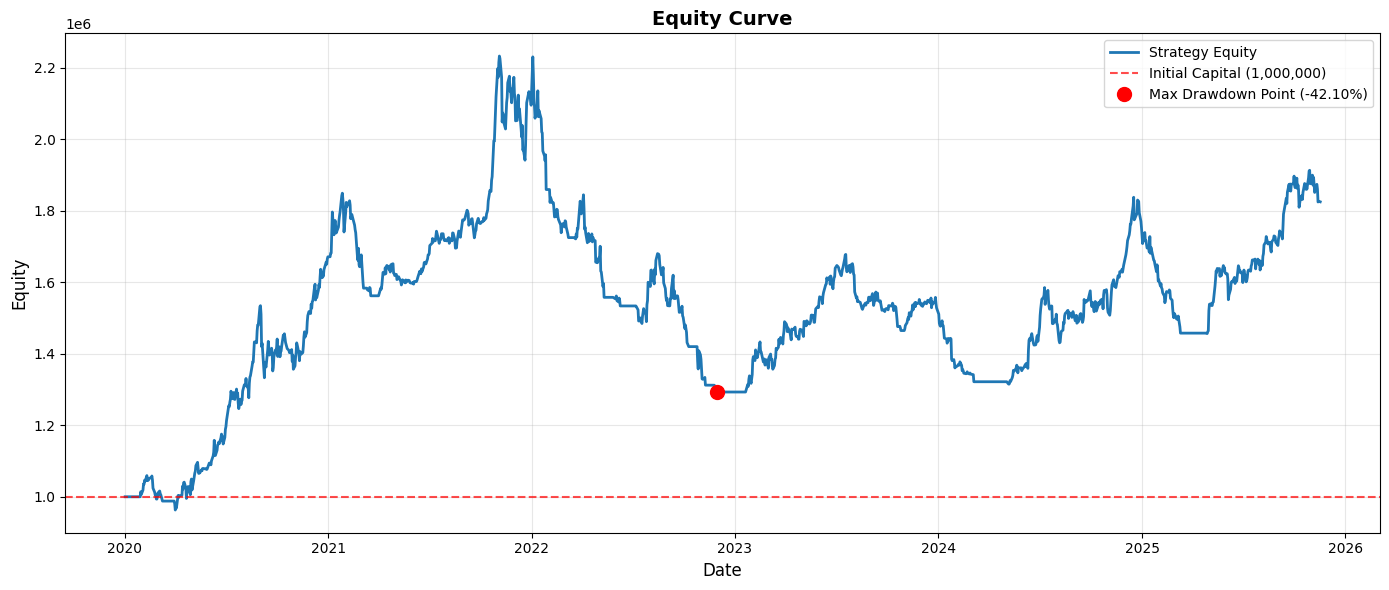


Plotting drawdown curve...


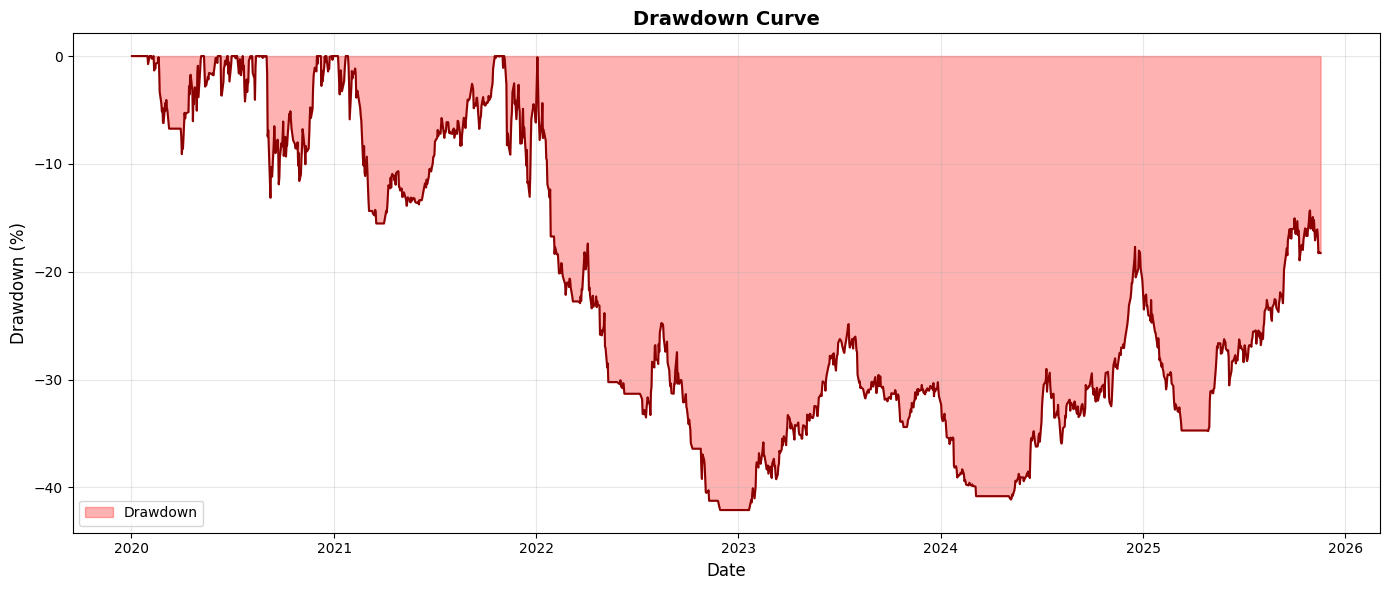


Plotting trade distribution...


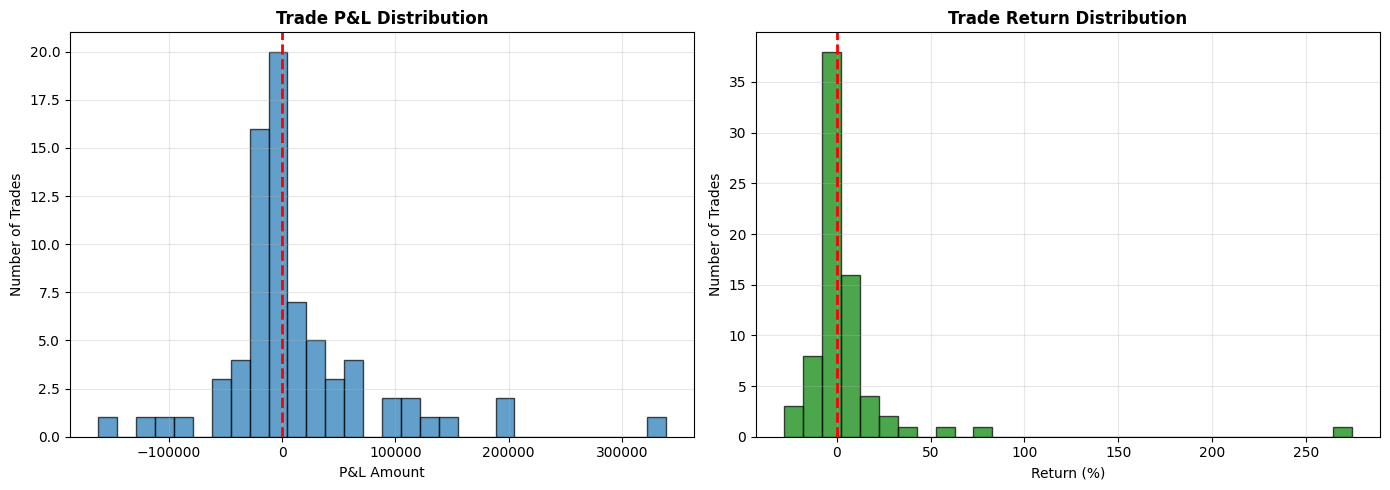


Plotting monthly returns...


/var/folders/k0/mjnvdkdj7sn_zbtz76h68xr40000gn/T/ipykernel_32526/3792050575.py:372: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_equity = self.equity_curve.resample('M').last()


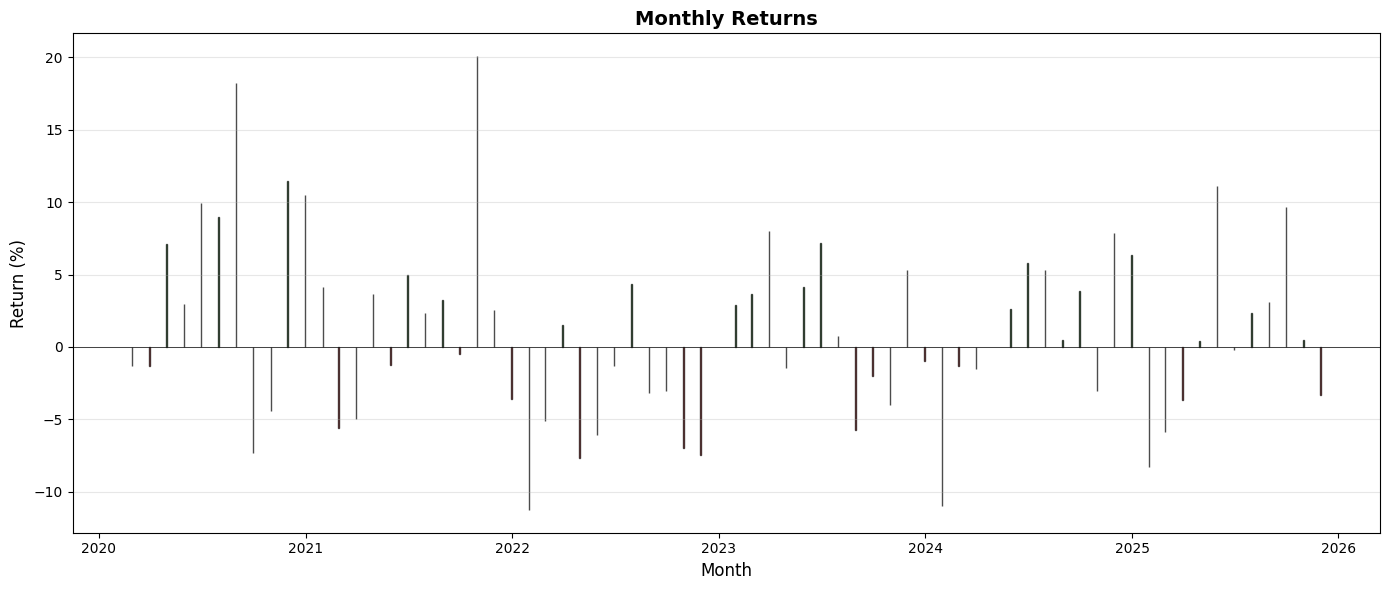


All metrics DataFrame:
                    數值
總報酬率      1.825328e+00
年化報酬率     1.932173e-01
年化波動率     1.835715e-01
Sharpe    6.512996e-01
最大回撤     -4.209680e-01
最終權益      1.825328e+06
最終現金      9.325860e+05
總交易次數     7.500000e+01
獲利交易次數    3.400000e+01
虧損交易次數    4.100000e+01
持平交易次數    0.000000e+00
勝率        4.533333e-01
平均獲利      5.938342e+04
平均虧損      2.911483e+04
盈虧比       2.039628e+00
總獲利       2.019036e+06
總虧損       1.193708e+06
淨獲利       8.253283e+05
最大單筆獲利    3.387452e+05
最大單筆虧損   -1.622345e+05
平均持倉天數    4.966667e+01
平均報酬率     5.886288e-02
最大連續獲利次數  4.000000e+00
最大連續虧損次數  9.000000e+00


In [35]:
# 使用範例：展示交易績效指標

# 使用之前的回測結果
# 建立績效指標物件
metrics = PerformanceMetrics(
    trades=trades,
    stats=stats,
    equity_curve=results['equity_curve'],
    initial_capital=1_000_000
)

# 方法 1：顯示完整摘要
print("=" * 80)
print("Method 1: Display Full Summary")
print("=" * 80)
metrics.show_summary()

# 方法 2：按股票分組顯示
print("\n")
metrics.show_by_symbol()

# 方法 3：繪製各種圖表
print("\nPlotting equity curve...")
metrics.plot_equity_curve()

print("\nPlotting drawdown curve...")
metrics.plot_drawdown()

print("\nPlotting trade distribution...")
metrics.plot_trade_distribution()

print("\nPlotting monthly returns...")
metrics.plot_monthly_returns()

# 方法 4：取得所有指標的 DataFrame
print("\nAll metrics DataFrame:")
metrics_df = metrics.get_metrics_dataframe()
print(metrics_df)

# 方法 5：一次顯示所有內容（取消註解以執行）
# metrics.show_all()


In [36]:
# metrics_df 裡面有所有指標跟數值
metrics_df

,數值
總報酬率,1.825328e+00
年化報酬率,1.932173e-01
年化波動率,1.835715e-01
Sharpe,6.512996e-01
最大回撤,-4.209680e-01
最終權益,1.825328e+06
最終現金,9.325860e+05
總交易次數,7.500000e+01
獲利交易次數,3.400000e+01
虧損交易次數,4.100000e+01
